In [1]:
%reload_ext autoreload
%autoreload 2

import json
import math
import os

import tqdm
import torch
import pyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from typing import Dict, Optional, NamedTuple

import mira
import mira.metamodel.io
import mira.modeling
import mira.modeling.viz
import mira.sources.petri

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, PetriNetODESystem, Time, State, Solution, Observation, get_name
from pyciemss.utils import state_flux_constraint

pyro.settings.set(module_local_params=True)
pyro.enable_validation(True)
pyro.set_rng_seed(0)
pyro.clear_param_store()

In [2]:
class Scenario3Model(PetriNetODESystem):

    def __init__(self, G, *, noise_scale: float = 1):
        super().__init__(G)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))

        # set priors on the rate parameters
        for param in self.G.parameters.values():
            prior_loc = torch.log(torch.as_tensor(param.value if param.value is not None else 0.01))
            prior_scale = torch.as_tensor(0.1)
            setattr(self, get_name(param), pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale)))

        # set priors on the initial state at the start of the training window
        for var in self.G.variables.values():
            prior_loc = torch.log(torch.as_tensor(var.data["initial_value"]))
            prior_scale = torch.as_tensor(1.)
            setattr(
                self,
                f"default_initial_state_{get_name(var)}",
                pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale))
            )
       
    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        data = {} if data is None else data
        output = []
        for name, value in zip(self.var_order, solution):
            output.append(pyro.sample(
                name,
                dist.Normal(value, self.noise_scale).to_event(1),
                obs=data.get(name, None),
            ))
        return tuple(output)


In [3]:
MODEL_PATH = "../../../program-milestones/6-month-milestone/evaluation/"

MODEL_FILES = {
    "biomd958": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958_mira.json"),
    ),
    "biomd960": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960_mira.json"),
    ),
    "sir": (
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir.json"),
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir_mira.json"),
    ),
}

DATA_ALIGNMENTS = {
    "biomd958": {
        "I": "Infectious",
        "H": "Hospitalised",
        "R": "Recovered",
        "D": "Fatalities",
    },
    "biomd960": {
        "I": "Infectious",
        "H": "Hospitalized",
        "R": "Recovered",
        "D": "Deceased",
    },
    "sir": {
        "I": "infected_population",
        "R": "immune_population",
    },
}

DATA_SCALE = {
    "biomd958": 1e3,
    "biomd960": 1.,
    "sir": 1e7,
}

def load_data(filename, model_name, interval: Optional[tuple] = None):
    df = pd.read_csv(filename)
    alignment = DATA_ALIGNMENTS[model_name]

    dates = pd.to_datetime(df["date"])
    
    if interval is not None:
        start, end = interval
        dates_mask = (dates >= start) & (dates <= end)

    tspan = torch.as_tensor(np.array(
        ((dates[dates_mask] if interval is not None else dates) - dates.iloc[0]).dt.total_seconds() / (24 * 60 * 60)
    ))

    obs = {
        alignment[col]: torch.tensor(
            (df[col][dates_mask] if interval is not None else df[col]).values
        ) / DATA_SCALE[model_name]
        for col in df.columns if col in alignment
    }

    return tspan, obs

In [4]:
def infer_parameters_advi(model, guide, data, tspan, num_iterations, **optim_params):

    loss_fn = pyro.infer.Trace_ELBO()(model, guide)

    # initialize parameters
    with torch.no_grad():
        loss_fn(None, tspan, data)

    optimizer = torch.optim.Adam(loss_fn.parameters(), **optim_params)

    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = loss_fn(None, tspan, data)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"iteration {i}: loss = {loss.item()}")

## Basic SIR model

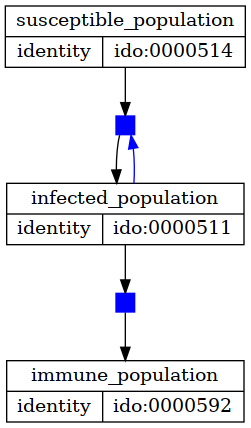

In [11]:
MODEL_NAME = "sir"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(0, 1))  #10. / DATA_SCALE[MODEL_NAME])

train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)
full_tspan = torch.cat([train_tspan, test_tspan])
full_data = {k: torch.cat([train_data[k], test_data[k]]) for k in train_data}

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

Initial state:  {'immune_population': tensor(4.5606), 'infected_population': tensor(3.6285), 'susceptible_population': tensor(1.3132)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


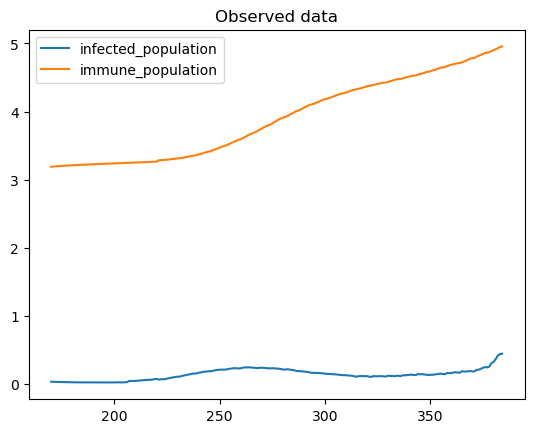

In [12]:
for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [7]:
guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(pyro.poutine.block(model, hide=list(model.var_order.keys())))
infer_parameters_advi(model, guide, train_data, train_tspan, 500, lr=1e-2)

/home/eli/development/pyro/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'susceptible_population'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


iteration 0: loss = 524.6644287109375
iteration 10: loss = 367.4508972167969
iteration 20: loss = 326.355712890625
iteration 30: loss = 284.8157043457031
iteration 40: loss = 234.21653747558594
iteration 50: loss = 233.80645751953125
iteration 60: loss = 193.71681213378906
iteration 70: loss = 167.517578125
iteration 80: loss = 141.17919921875
iteration 90: loss = 82.90144348144531
iteration 100: loss = 108.31987762451172
iteration 110: loss = 88.11534881591797
iteration 120: loss = 90.95166015625
iteration 130: loss = 56.449684143066406
iteration 140: loss = 94.67776489257812
iteration 150: loss = 126.09803771972656
iteration 160: loss = 63.77617263793945
iteration 170: loss = 64.7857437133789
iteration 180: loss = 46.234649658203125
iteration 190: loss = 50.49211883544922
iteration 200: loss = 52.22076416015625
iteration 210: loss = 40.28415298461914
iteration 220: loss = 27.14862632751465
iteration 230: loss = 28.08064079284668
iteration 240: loss = 14.51810359954834
iteration 250: 

dict_keys(['default_initial_state_immune_population', 'default_initial_state_infected_population', 'default_initial_state_susceptible_population', 'a_beta', 'a_gamma', 'noise_scale'])


Text(0.5, 1.0, "Posterior predictive distribution for model sir (approx: <class 'pyro.infer.autoguide.guides.AutoLowRankMultivariateNormal'>)")

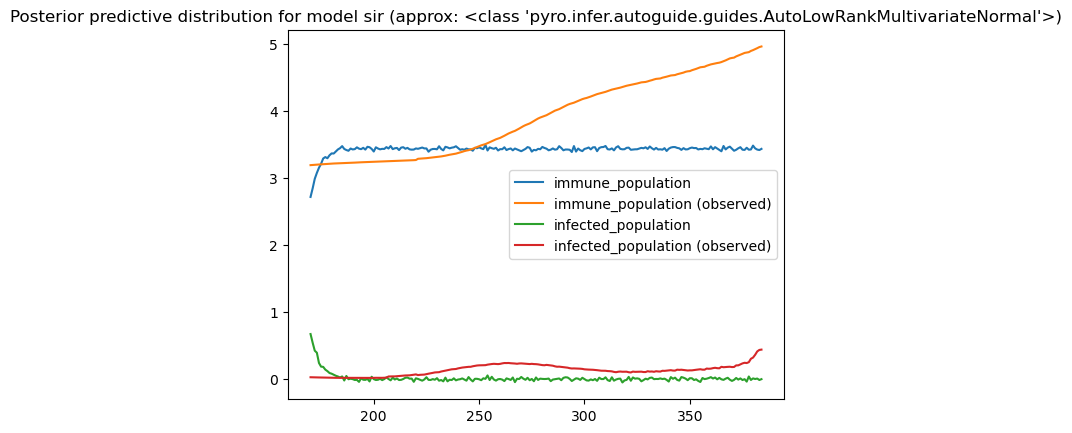

In [13]:
result = sample(model, 100, None, full_tspan, guide)
print(guide(None, full_tspan).keys())

for name in result.keys():
    if name in full_data:
        plt.plot(full_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(full_tspan, full_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")

## Model with asymptomatic cases and hospitalization

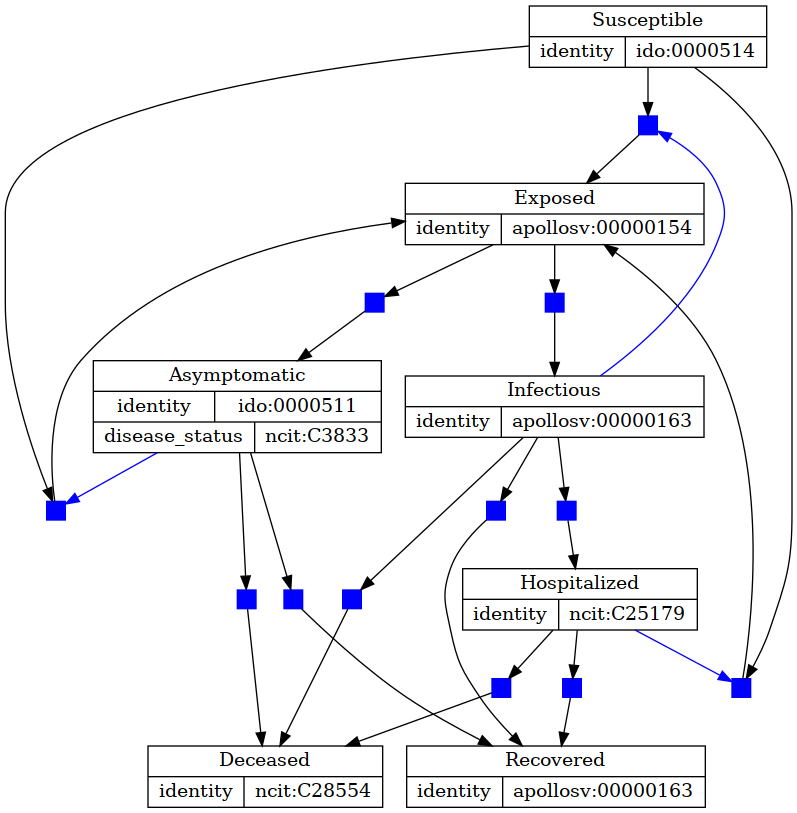

In [9]:
MODEL_NAME = "biomd960"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(math.log(1e7), 7))  #10. / DATA_SCALE[MODEL_NAME])

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

In [ ]:
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)
full_tspan = torch.cat([train_tspan, test_tspan])
full_data = {k: torch.cat([train_data[k], test_data[k]]) for k in train_data}

for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [ ]:
NUM_ITERATIONS = 500
OPTIM_PARAMS = {"lr": 1e-2}

guide = pyro.infer.autoguide.AutoDelta(
    pyro.poutine.block(model, hide=list(model.var_order.keys())),
    init_loc_fn=pyro.infer.autoguide.initialization.init_to_feasible,
)
infer_parameters_advi(model, guide, train_data, train_tspan, NUM_ITERATIONS, **OPTIM_PARAMS)

In [ ]:
result = sample(model, 100, None, full_tspan, guide)

for name in result.keys():
    if name in full_data:
        plt.plot(full_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(full_tspan, full_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")

## Model with asymptomatic and super-spreader infected individuals

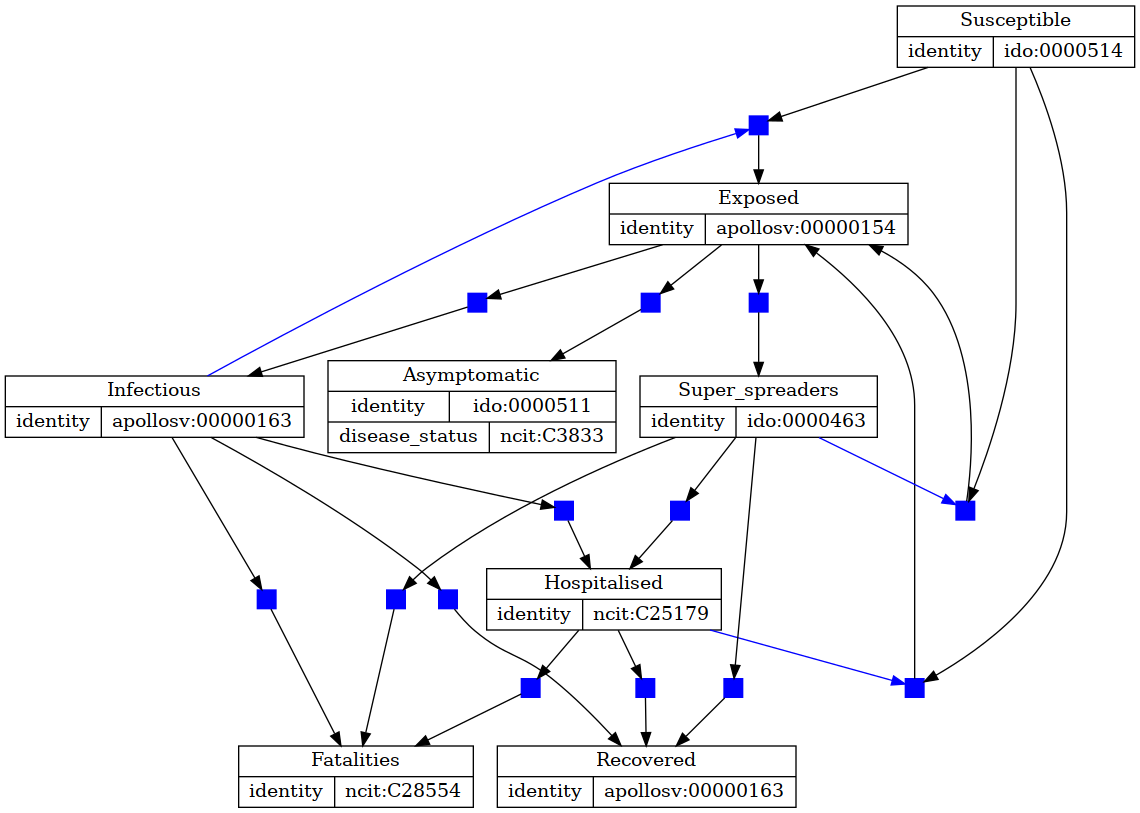

In [10]:
MODEL_NAME = "biomd958"

DATA_FILE = "usa-IRDVHN_age.csv"
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(0, 1))  #10. / DATA_SCALE[MODEL_NAME])

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

In [ ]:
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)
full_tspan = torch.cat([train_tspan, test_tspan])
full_data = {k: torch.cat([train_data[k], test_data[k]]) for k in train_data}

for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [ ]:
NUM_ITERATIONS = 500
OPTIM_PARAMS = {"lr": 1e-4}

guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, hide=list(model.var_order.keys())))
infer_parameters_advi(model, guide, train_data, train_tspan, NUM_ITERATIONS, **OPTIM_PARAMS)

In [ ]:
result = sample(model, 100, None, train_tspan, guide)

for name in result.keys():
    if name in full_data:
        plt.plot(full_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(full_tspan, full_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")